# Setup

In this notebook, we will demonstrate various sampling methods in Pandas and Dask. To illustrate the methods, we use a dataset on the [annual number of objects launched into space from Our World in Data](https://ourworldindata.org/grapher/yearly-number-of-objects-launched-into-outer-space) and hosted in [Tidy Tuesday's Repository](https://github.com/rfordatascience/tidytuesday/blob/main/data/2024/2024-04-23/readme.md).

In [1]:
%load_ext dotenv
%dotenv 
%run update_path.py

In [2]:
import dask.dataframe as dd
from glob import glob
from utils.logger import get_logger
_logs = get_logger(__name__)

In [3]:
import pandas as pd
outer_space_dt = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-04-23/outer_space_objects.csv')

In [4]:
outer_space_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175 entries, 0 to 1174
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Entity       1175 non-null   object
 1   Code         1033 non-null   object
 2   Year         1175 non-null   int64 
 3   num_objects  1175 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 36.8+ KB


In [5]:
idx = outer_space_dt['Year'] >= 2020
idx &= outer_space_dt['Entity'] != 'World'
outer_space_dt = outer_space_dt[idx]

# Sampling in Python

There are different packages that allow sampling. A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```python
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [6]:
outer_space_dt.sample(n = 10, random_state = 42)

,Entity,Code,Year,num_objects
930,Taiwan,TWN,2021,2
841,Saudi Arabia,SAU,2021,2
917,Sweden,SWE,2022,1
408,Hungary,HUN,2021,2
712,Netherlands,NLD,2023,2
199,Colombia,COL,2023,1
1090,United States,USA,2022,1939
398,Germany,DEU,2022,5
735,Norway,NOR,2022,3
965,Uganda,UGA,2022,1


In [7]:
import random
random.seed(42)
frac = 0.5

simple_sample_dt = outer_space_dt.sample(frac = frac)
simple_sample_dt.shape, outer_space_dt.shape

((82, 4), (165, 4))

## Stratified Sampling

Use `groupby()` and `.sample()` for stratified sampling.

In [8]:
strat_sample_dt=outer_space_dt.groupby('Entity').sample(frac=frac, random_state=42)
strat_sample_dt.shape, outer_space_dt.shape

((74, 4), (165, 4))

/var/folders/1j/g6gn9jdj7vq3r3l5v3v24khm0000gn/T/ipykernel_8411/379262615.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=combined_df, x='Entity', y='count', col='sample_type',


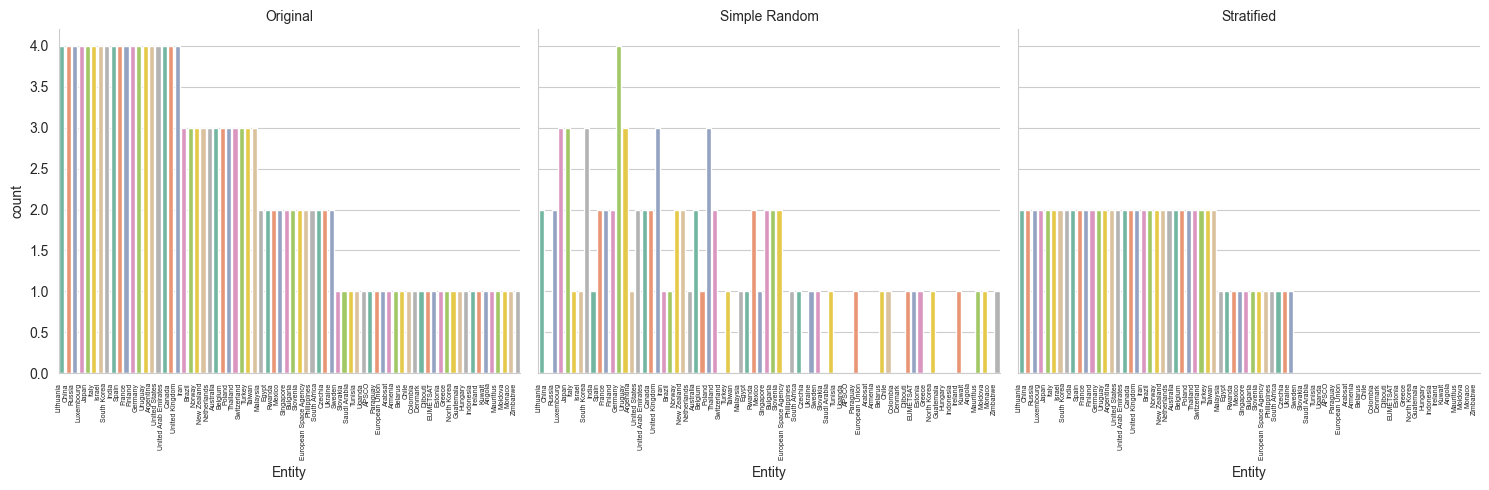

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for comparison
df_orig = outer_space_dt['Entity'].value_counts().reset_index()
df_orig.columns = ['Entity', 'count']
df_orig['sample_type'] = 'Original'

df_simple = simple_sample_dt['Entity'].value_counts().reset_index()
df_simple.columns = ['Entity', 'count']
df_simple['sample_type'] = 'Simple Random'

df_strat = strat_sample_dt['Entity'].value_counts().reset_index()
df_strat.columns = ['Entity', 'count']
df_strat['sample_type'] = 'Stratified'

# Combine all data
combined_df = pd.concat([df_orig, df_simple, df_strat])

# Create faceted plot
sns.set_style("whitegrid")
g = sns.catplot(data=combined_df, x='Entity', y='count', col='sample_type', 
                kind='bar', height=5, aspect=1, palette='Set2')
g.set_xticklabels(rotation=90, ha='right', fontsize=5)
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

# Sampling in Dask

Stratified sampling in Dask works somewhat differently. The code below will raise a Key Error (the "key" *sample* is not found).

```python
strat_sample_dd = (dd_dt.groupby('Entity', group_keys=False)
                        .sample(frac = frac)
                        .compute())
```

However, stratified sampling in Dask can be done with `groupby().apply()` and a lambda function.

In [10]:
dd_dt = dd.from_pandas(outer_space_dt, npartitions=4)

strat_sample_dd = (dd_dt
                      .groupby('Entity', group_keys=False)
                      .apply(lambda x: x.sample(frac = frac))
                      .compute()
                      .reset_index())


/var/folders/1j/g6gn9jdj7vq3r3l5v3v24khm0000gn/T/ipykernel_8411/1528662781.py:5: UserWarning: `meta` is not specified, inferred from partial data.
Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result

  .apply(lambda x: x.sample(frac = frac))
/Users/ashutosh/production/production-env/lib/python3.14/site-packages/dask/dataframe/groupby.py:122: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return g.apply(func, *args, **kwargs)
/Users/ashutosh/production/production-env/lib/python3.14/site-packages/dask/dataframe/groupby.py:122: FutureWarning: 